In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
tf.set_random_seed(777)

In [15]:
#paremeter set
learning_rate = 0.001
training_epoch=10
batch_size=90
n_classes=2
img_size=[1,50,50,3]
classes=['paper','rock']

In [16]:
#일정 비율로 training/test나누기
def MakeData(x,y,prop):
  
  train_prop = prop
  num_data = int(x.shape[0]/2)
  num_train = int(num_data*train_prop)
  
  x_train = x[:num_train]
  x_train = np.append(x_train, x[num_data:num_data+num_train],axis=0)
  
  x_test = x[num_train:num_data]
  x_test = np.append(x_test, x[num_data+num_train:],axis=0)
  
  y_train = y[:num_train]
  y_train = np.append(y_train, y[num_data:num_data+num_train],axis=0)
  
  y_test = y[num_train:num_data]
  y_test = np.append(y_test, y[num_data+num_train:],axis=0)
  
  print('X data:',x.shape, ',Y data:',y.shape)
  print('X train:',x_train.shape, ',Y train:',y_train.shape)
  print('X test:',x_test.shape, ',Y test:',y_test.shape)
  
  return (x_train,y_train),(x_test,y_test)

#랜덤 배치 생성 
def next_batch(num, data, labels):
    idx = np.arange(0,len(data))
    np.random.shuffle(idx)
    idx=idx[:num]
    data_shuffle=[data[i] for i in idx]
    labels_shuffle=[labels[i] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)
  
  
#plt를 이용해서 사진 뽑아보기
def Showimg(type, num):
  plt.grid(None) 
  if type=='train':
    img = x_train[num]
    plt.imshow(img)
    plt.show()
    print(int(y_train[num][0]),classes[int(y_train[num][0])])
    
  elif type=='test':
    img = x_test[num]
    plt.imshow(img)
    plt.show()
    print(int(y_test[num][0]),classes[int(y_test[num][0])])
    
  elif type=='data':
    img = x_data[num]
    plt.imshow(img)
    plt.show()
    print(int(y_data[num][0]),classes[int(y_data[num][0])])
  

In [21]:
#데이터 읽어오기 0:paper 1:rock
data_dir = './sub/data_resize/'
class_list = os.listdir(data_dir)
first_flag = True

data_num=900

for data_class in class_list:
    data_class_list = os.listdir(data_dir+data_class)
    limit_num=data_num
    for data_name in data_class_list:
        if limit_num==0:
          break
                
        img = plt.imread(data_dir+data_class+'/'+data_name)
        img = np.reshape(img,img_size)
        if first_flag:
            x_data=img
            first_flag = False
        else:
            x_data=np.append(x_data,img,axis=0)

        limit_num-=1

y_data = np.zeros([data_num])
y_data = np.append(y_data, np.ones([data_num]))
y_data = np.reshape(y_data,[data_num*2,-1])

(x_train, y_train), (x_test, y_test) = MakeData(x_data,y_data,0.9)

print('Reading Data Success!')


X data: (1800, 50, 50, 3) ,Y data: (1800, 1)
X train: (1620, 50, 50, 3) ,Y train: (1620, 1)
X test: (180, 50, 50, 3) ,Y test: (180, 1)
Reading Data Success!


In [22]:
X = tf.placeholder(tf.float32,[None,50,50,3])
Y = tf.placeholder(tf.int64,[None,1])
Y_one_hot = tf.one_hot(Y,n_classes) 
Y_one_hot = tf.reshape(Y_one_hot,[-1,n_classes]) #shape맞춰줌

L1 = tf.layers.conv2d(X,64,[3,3],padding='SAME',activation=tf.nn.relu)
L1 = tf.layers.max_pooling2d(L1,[2,2],[2,2],padding='SAME')

L2 = tf.layers.conv2d(L1,128,[3,3],padding='SAME',activation=tf.nn.relu)
L2 = tf.layers.max_pooling2d(L2,[2,2],[2,2],padding='SAME')

L3 = tf.layers.conv2d(L2,256,[3,3],padding='SAME',activation=tf.nn.relu)
L3 = tf.layers.max_pooling2d(L3,[2,2],[2,2],padding='SAME')

L4 = tf.layers.flatten(L3)
L4 = tf.layers.dense(L4,256,activation=tf.nn.sigmoid)
logits = tf.layers.dense(L4,n_classes,activation=None)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

prediction = tf.argmax(logits,axis=1)
is_correct=tf.equal(prediction,tf.argmax(Y_one_hot,1))
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

AttributeError: module 'tensorflow.python.layers.layers' has no attribute 'flatten'

In [0]:
X = tf.placeholder(tf.float32,[None,200,200,3])
X_flat = tf.reshape(X,[-1,120000])
Y = tf.placeholder(tf.int64,[None,1])
Y_one_hot = tf.one_hot(Y,2) 
Y_one_hot = tf.reshape(Y_one_hot,[-1,2]) #shape맞춰줌

L1 = tf.layers.dense(X_flat, 256, activation = tf.nn.relu)
L2 = tf.layers.dense(L1, 512, activation = tf.nn.relu)
L3 = tf.layers.dense(L2, 512, activation = tf.nn.relu)

logits = tf.layers.dense(L3,2, activation = tf.nn.sigmoid)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y_one_hot));
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

prediction = tf.argmax(logits,axis=1)
is_correct=tf.equal(prediction,tf.argmax(Y_one_hot,1))
accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))



In [20]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
total_batch = int(x_train.shape[0]/batch_size)
print('Total batch:{:d}'.format(total_batch))
print('Batch Size:{:d}'.format(batch_size))
print('Learning Start')
for epoch in range(training_epoch):
    c_avg = 0
    for i in range(total_batch):
        batch_xs, batch_ys = next_batch(batch_size,x_data,y_data)
        c,_=sess.run([cost,optimizer],feed_dict={X:batch_xs,Y:batch_ys})
        c_avg+=c/total_batch
    
    print('Epoch: {:03d}'.format(epoch+1),'Cost:%.9f'%c_avg)
    
    #학습데이터 정확도 출력
    xs,ys=next_batch(180,x_train,y_train)
    print('Training_Acc:{:.5f}'.format(sess.run(accuracy,feed_dict={X:xs,Y:ys})))
    
print('Learning Finished')    



Total batch:2
Batch Size:90
Learning Start
Epoch: 001 Cost:0.813261747
Training_Acc:0.50000
Epoch: 002 Cost:0.813261747
Training_Acc:0.50000
Epoch: 003 Cost:0.813261747
Training_Acc:0.50000
Epoch: 004 Cost:0.813261747
Training_Acc:0.50000
Epoch: 005 Cost:0.813261747
Training_Acc:0.50000
Epoch: 006 Cost:0.813261747
Training_Acc:0.50000
Epoch: 007 Cost:0.813261747
Training_Acc:0.50000
Epoch: 008 Cost:0.813261747
Training_Acc:0.50000
Epoch: 009 Cost:0.813261747
Training_Acc:0.50000
Epoch: 010 Cost:0.813261747
Training_Acc:0.50000
Learning Finished


In [9]:
b=sess.run(Y_one_hot,feed_dict={Y:y_data[95:105]})
print(b)
print(sess.run(tf.argmax(b,axis=1)))

print(sess.run(logits,feed_dict={X:x_data[95:105]}))
print(sess.run(prediction,feed_dict={X:x_data[95:105]}))
print(sess.run(is_correct,feed_dict={X:x_data[95:105],Y:y_data[95:105]}))


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[0 0 0 0 0 1 1 1 1 1]
[[-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]
 [-0.6334624 -0.186968 ]]
[1 1 1 1 1 1 1 1 1 1]
[False False False False False  True  True  True  True  True]


Accuracy: 50.000000 %


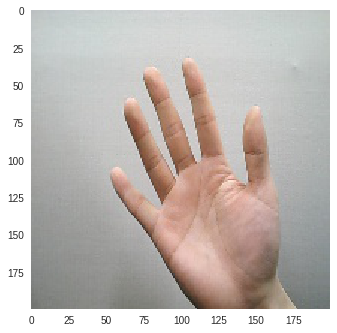

0 paper


In [8]:
xs, ys = next_batch(200,x_train,y_train)
acc=sess.run(accuracy, feed_dict={X:x_data, Y:y_data})
#print('Accuracy:','%5f'%(100*acc),'%')

test_num=31
Showimg('train',test_num)
#print('Predict:',sess.run([prediction,logits], feed_dict={X:np.reshape(x_train[test_num],img_size)}))
#print('Real:',sess.run(Y_one_hot, feed_dict={Y:np.reshape(y_train[test_num]}))

In [10]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive
